# Redes adversarias generativas condicionales

In [1]:
import deepchem as dc
import numpy as np
import tensorflow as tf

Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (C:\Users\alloh\Miniconda3\lib\site-packages\deepchem\models\torch_models\__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


In [2]:
tf.__version__

'2.10.1'

Una Red Generativa Adversaria (GAN) es un tipo de modelo generativo. Consta de dos partes llamadas "generador" y "discriminador". El generador toma valores aleatorios como entrada y los transforma en una salida que (con suerte) se asemeja a los datos de entrenamiento. El discriminador toma un conjunto de muestras como entrada y trata de distinguir las muestras reales de entrenamiento de las creadas por el generador. Ambos se entrenan juntos. El discriminador intenta mejorar su capacidad para diferenciar datos reales de datos falsos, mientras que el generador intenta mejorar su habilidad para engañar al discriminador.

Un Generador Adversario Condicional (CGAN) permite entradas adicionales para el generador y el discriminador, y su salida está condicionada en esas entradas adicionales. Por ejemplo, esto podría ser una etiqueta de clase, y el CGAN intenta aprender cómo varía la distribución de datos entre las clases.


En este ejemplo, crearemos una distribución de datos que consiste en un conjunto de elipses en 2D, cada una con una posición, forma y orientación aleatoria. Cada clase corresponde a una elipse diferente. Generaremos aleatoriamente las elipses. Para cada una, seleccionamos una posición central, un tamaño en X e Y y un ángulo de rotación aleatorios. Luego creamos una matriz de transformación que mapea el círculo unitario a la elipse.


Es decir, lo que hacemos es generar un espacio donde se van a generar nuestros puntos aleatoriamente. Esos espacios donde se generaran puntos serán elipses de formas, orientaciones y angulos aleatorios

In [3]:
n_classes = 4
class_centers = np.random.uniform(-4, 4, (n_classes, 2))
class_transforms = []
for i in range(n_classes):
    xscale = np.random.uniform(0.5, 2)
    yscale = np.random.uniform(0.5, 2)
    angle = np.random.uniform(0, np.pi)
    m = [[xscale*np.cos(angle), -yscale*np.sin(angle)],
         [xscale*np.sin(angle), yscale*np.cos(angle)]]
    class_transforms.append(m)
class_transforms = np.array(class_transforms)

La siguiente función generará datos aleatorios de la distribución. Por cada punto, escoge una clase aleatoria y una posición aleatoria dentro de esa clase elipse

Una vez definida nuestros espacios, generamos puntos dentro de esos espacios y los etiquetamos en función de la clase a la que pertenezca

In [4]:
def generate_data(n_points):
    classes = np.random.randint(n_classes, size=n_points)
    r = np.random.random(n_points) #Posicion aleatoria
    angle = 2*np.pi*np.random.random(n_points) #Angulo aleatorio
    points = (r*np.array([np.cos(angle), np.sin(angle)])).T
    points = np.einsum('ijk,ik->ij', class_transforms[classes], points)
    points += class_centers[classes]
    return classes, points

Si generamos datos, podremos ver que tendremos dos arrays. Uno que nos indica la clase y otro los puntos que estaran dentro de una elipse

In [5]:
generate_data(100)

(array([3, 2, 0, 2, 3, 0, 3, 3, 0, 0, 1, 2, 1, 1, 3, 2, 2, 2, 0, 3, 3, 3,
        0, 3, 3, 0, 3, 2, 2, 3, 3, 2, 1, 1, 2, 2, 0, 0, 1, 2, 3, 0, 0, 1,
        3, 2, 3, 1, 2, 2, 3, 1, 2, 1, 0, 1, 1, 2, 3, 1, 0, 2, 0, 3, 1, 1,
        0, 1, 1, 0, 1, 2, 1, 3, 3, 3, 2, 3, 0, 3, 3, 2, 2, 0, 2, 2, 3, 1,
        1, 2, 0, 2, 2, 0, 2, 0, 3, 1, 0, 1]),
 array([[ 0.82197982,  2.14538353],
        [ 1.9128986 ,  2.78046993],
        [-3.6928118 ,  1.29461752],
        [ 1.22652095,  1.97917495],
        [ 0.38745218,  3.55249443],
        [-3.92787263,  1.81149416],
        [-0.40410558,  3.32300416],
        [-0.15904224,  3.03344886],
        [-3.7064228 ,  1.56911946],
        [-3.852685  ,  1.63258369],
        [-1.8093149 ,  3.2308226 ],
        [ 1.48115449,  2.33673426],
        [-1.53259099,  3.59434309],
        [-1.45273625,  3.68544746],
        [-0.55464183,  3.26666364],
        [ 1.66927856,  2.21986622],
        [ 0.75398669,  2.65573421],
        [ 1.60088132,  3.53450118],
        [-

Veamos a hora la distribución de nuestro conjunto de datos mediante una gráfica. Cada color denota una clase

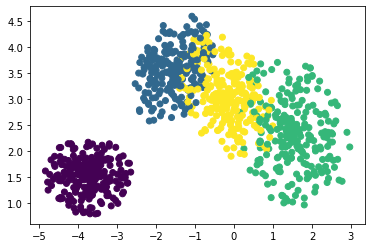

In [6]:
%matplotlib inline
import matplotlib.pyplot as plot
classes, points = generate_data(1000)
plot.scatter(x=points[:,0], y=points[:,1], c=classes)


Ahora creemos el modelo para nuestro CGAN. La clase GAN de DeepChem hace que esto sea muy fácil. Simplemente la subclasificamos e implementamos algunos métodos. Los dos más importantes son:

- `create_generator()`: construye un modelo que implementa el generador. El modelo toma como entrada un lote de ruido aleatorio más cualquier variable condicional (en nuestro caso, la clase codificada en one-hot de cada muestra). Su salida es una muestra sintética que se supone que se parece a los datos de entrenamiento.

- `create_discriminator()`: construye un modelo que implementa el discriminador. El modelo toma como entrada las muestras a evaluar (que pueden ser datos de entrenamiento reales o muestras sintéticas creadas por el generador) y las variables condicionales. Su salida es un solo número para cada muestra, que se interpretará como la probabilidad de que la muestra sea un dato de entrenamiento real.

En este caso, usamos modelos muy simples. Simplemente concatenan las entradas y las pasan a través de algunas capas densas. Observa que la capa final del discriminador utiliza una activación sigmoide. Esto garantiza que produzca una salida entre 0 y 1 que se puede interpretar como una probabilidad.

También debemos implementar algunos métodos que definen las formas de las diversas entradas. Especificamos que el ruido aleatorio proporcionado al generador debe consistir en diez números para cada muestra; que cada muestra de datos consta de dos números (las coordenadas X e Y de un punto en 2D); y que la entrada condicional consta de n_classes números para cada muestra (el índice de clase codificado en one-hot).


In [7]:
from tensorflow.keras.layers import Concatenate, Dense, Input

class ExampleGAN(dc.models.GAN): #Heredamos de la clase models.GAN

    '''
    Estos métodos devuelven las formas de entrada para el generador (ruido),
    los datos y la entrada condicional. En este caso,
    el generador espera una entrada de ruido de forma (10,),
    los datos de forma (2,), y la entrada condicional de forma (n_classes,)
    '''
    def get_noise_input_shape(self):
        return (10,)

    def get_data_input_shapes(self):
        return [(2,)]

    def get_conditional_input_shapes(self):
        return [(n_classes,)]
    
    #Definimos la arquitectura de la red generadora
    def create_generator(self):
        noise_in = Input(shape=(10,)) #Entrada para el ruido
        conditional_in = Input(shape=(n_classes,)) #Entrada condicional (labels)
        gen_in = Concatenate()([noise_in, conditional_in]) #Concatenamos las entradas
        gen_dense1 = Dense(30, activation=tf.nn.relu)(gen_in) #Una capa densa con f.a. ReLU
        gen_dense2 = Dense(30, activation=tf.nn.relu)(gen_dense1) #Otra capa densa con f.a. ReLU
        generator_points = Dense(2)(gen_dense2) #Capa densa de salida. Produce los puntos. Tiene forma de salida (2,)
                                                #ya que producimos puntos en un espacio bidimensional
        return tf.keras.Model(inputs=[noise_in, conditional_in], outputs=[generator_points])

    #Definimos la arquitectura de la red discriminadora
    def create_discriminator(self):
        data_in = Input(shape=(2,)) #Entrada para datos
        conditional_in = Input(shape=(n_classes,)) #Entrada condicional
        discrim_in = Concatenate()([data_in, conditional_in]) #Concatenamos las entradas
        discrim_dense1 = Dense(30, activation=tf.nn.relu)(discrim_in) #Capa densa con ReLU
        discrim_dense2 = Dense(30, activation=tf.nn.relu)(discrim_dense1) #Capa densa con ReLU
        discrim_prob = Dense(1, activation=tf.sigmoid)(discrim_dense2) #Capa densa de salida con f.a. sigmoide que producirá 
                                                                       #una probabilidad de que los datos sean o no reales
        return tf.keras.Model(inputs=[data_in, conditional_in], outputs=[discrim_prob])

gan = ExampleGAN(learning_rate=1e-4) #Establecemos una tasa de aprendizaje

Para ajustar el modelo, llamamos a `fit_gan()`. El argumento es un iterador que produce lotes de datos de entrenamiento. Más concretamente, debe producir diccionarios que asignen todos los datos de entrada y las entradas condicionales a los valores que se van a utilizar para ellos. En nuestro caso, podemos crear fácilmente la cantidad de datos aleatorios que necesitemos, por lo que definimos un generador que llama a la función `generate_data()` definida anteriormente para cada nuevo lote.


In [16]:
def iterbatches(batches):
    for i in range(batches): 
        classes, points = generate_data(gan.batch_size)
        classes = dc.metrics.to_one_hot(classes, n_classes)
        #Creamos el generador
        yield {gan.data_inputs[0]: points, gan.conditional_inputs[0]: classes}


In [18]:
#Función que nos va a generar datos en lotes
def iterbatches(batches):
    for i in range(batches): #Por cada lote
        classes, points = generate_data(gan.batch_size) #Generamos los puntos con sus etiquetas
        classes = dc.metrics.to_one_hot(classes, n_classes) #Convertimos las etiquetas clases en un vector one-hot
        #Creamos el generador
        yield {gan.data_inputs[0]: points, gan.conditional_inputs[0]: classes} #Cada vez que llamamos a esta 
                                                                               #función generamos un nuevo lote de datos
#Entrenamos nuestra gan
gan.fit_gan(iterbatches(5000)) #En este caso generamos 5000 lotes

Ending global_step 1103: generator average loss 0.901473, discriminator average loss 1.13434
Ending global_step 2103: generator average loss 0.80147, discriminator average loss 1.275
Ending global_step 3103: generator average loss 0.697124, discriminator average loss 1.39099
Ending global_step 4103: generator average loss 0.695659, discriminator average loss 1.3849
Ending global_step 5103: generator average loss 0.69502, discriminator average loss 1.38592
TIMING: model fitting took 135.724 s


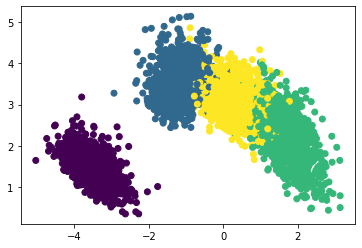

In [52]:
classes, points = generate_data(5000) #Generamos clases que luego generaremos (los puntos generados realmente no nos interesa)
one_hot_classes = dc.metrics.to_one_hot(classes, n_classes) #Metemos las clases en un onehot vector
gen_points = gan.predict_gan_generator(conditional_inputs=[one_hot_classes]) #Generamos puntos con nuestra red CGAN
plot.scatter(x=gen_points[:,0], y=gen_points[:,1], c=classes) #Los ploteamos